In [22]:
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
import openai

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
class Task(TypedDict):
    """Represent a task, i.e. a general subproblem of the user's prompt which needs to be solved."""
    
    name: Annotated[str, "The name of the task."]
    description: Annotated[str, "The description of the task."]
    expected_output: Annotated[str, "The expected output or contribution of the task."]


class Plan(TypedDict):
    """Represent a plan, i.e. a sequence of tasks which need to be solved in order to solve the user's prompt."""
    
    tasks: Annotated[list[Task], "The list of tasks which need to be solved in order to solve the user's prompt."]

In [3]:
class ProblemDecomposition(MessagesState):
    input_problem: str
    decomposed: bool = False
    plan: Plan

In [4]:
class Steps:
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0.5)
        self.eval_llm = ChatOpenAI(model="gpt-4o", temperature=0.7, stop_sequences=["<</STOP>>"])
        self.response_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3).with_structured_output(Plan)

    def intitial_problem_decomposition(self, state: ProblemDecomposition):
        system_prompt_text = """You are the AI component of a multi-agent AI system. Your task is to decompose a given problem into smaller tasks.
                                You always think before your answer. Always think on the language language of the user's input prompt."""
        
        suffix_instruction = """For first step specify some general tasks/problems/subquestion that's need to be solved to answer the
                            original question corretly. DO NOT decompose the task into too specific subtasks. I need more general one. These general
                            subtasks will be solved by special schemas."""
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt_text),
            ("human", "**User prompt:**\n{input_problem}\n---------\n" + suffix_instruction)
        ])

        chain = prompt | self.llm
        
        return {"messages": [*prompt.invoke(state["input_problem"]).to_messages(), chain.invoke(state["input_problem"])]}
    
    def self_evaluate(self, state: ProblemDecomposition):
        evaluation_prompt = """Check out the above generated tasks. Evalutate if they are relevant to solve or not relevant. 
                                In addition evaluate if they are general enough.
                                After the evaluation, say `<REFINE>` if you recommand to refine the tasks and says `<OK>` if refinement is not needed.
                                Be self-critical. In the refinement phase, you will decide whether to rephrase the task / group together more tasks / remove task from the list.
                                ALWAYS FINISH EVALUATION WITH `<OK><</STOP>>` or `<REFINE><</STOP>>` label."""
        
        prompt = ChatPromptTemplate.from_messages([
            *state["messages"],
            ("human", "{input}")
        ])

        chain = prompt | self.eval_llm

        context = [*prompt.invoke(evaluation_prompt).to_messages(), chain.invoke(evaluation_prompt)]

        if context[-1].content.endswith("<OK>"):
            return {"messages": context, "decomposed": True}
        else:
            return {"messages": context, "decomposed": False}
        
    def refine_tasks(self, state: ProblemDecomposition):
        refinement_prompt = """Refine the tasks. You can rephrase the task, group together more tasks or remove task from the list."""
        prompt = ChatPromptTemplate.from_messages([
            *state["messages"],
            ("human", "{input}")
        ])

        chain = prompt | self.llm

        return {"messages": [*prompt.invoke(refinement_prompt).to_messages(), chain.invoke(refinement_prompt)]}
    
    def finilize_decomposition(self, state: ProblemDecomposition):
        final_prompt = """You have successfully decomposed the problem into smaller tasks. Now based on the final refinement create 
                            the plan for the solver agent based on `Plan` schema."""
        prompt = ChatPromptTemplate.from_messages([
            *state["messages"],
            ("human", "{input}")
        ])

        chain = prompt | self.response_llm
        plan = chain.invoke(final_prompt)
        context = [*prompt.invoke(final_prompt).to_messages(), AIMessage(content=f"{plan}")]
        return {"messages": context, "plan": plan}
    
    def eval_router(self, state: ProblemDecomposition):
        if state["decomposed"]:
            return self.finilize_decomposition.__name__
        else:
            return self.refine_tasks.__name__


In [5]:
steps = Steps()

graph = StateGraph(ProblemDecomposition)
graph.add_node("problem_decomposition", steps.intitial_problem_decomposition)
graph.add_node("self_evaluate", steps.self_evaluate)
graph.add_node("refine_tasks", steps.refine_tasks)
graph.add_node("finilize_decomposition", steps.finilize_decomposition)

graph.add_edge(START, "problem_decomposition")
graph.add_edge("problem_decomposition", "self_evaluate")
graph.add_conditional_edges("self_evaluate", steps.eval_router)
graph.add_edge("refine_tasks", "self_evaluate")
graph.add_edge("finilize_decomposition", END)


graph = graph.compile()

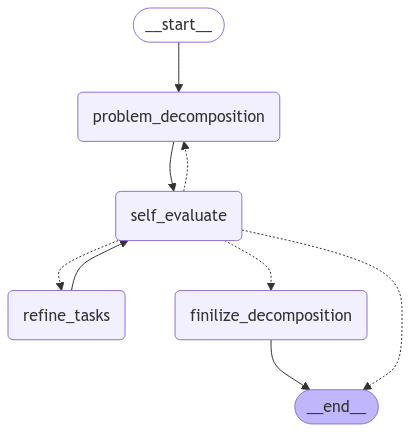

In [23]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [ ]:
for task in graph.stream({"input_problem": "How to build a house?"}):
    print(task)
    print("----------------")
task["finilize_decomposition"]["plan"]

{'problem_decomposition': {'messages': [SystemMessage(content="You are the AI component of a multi-agent AI system. Your task is to decompose a given problem into smaller tasks.\n                                You always think before your answer. Always think on the language language of the user's input prompt.", additional_kwargs={}, response_metadata={}, id='09dfbae3-dba2-45c9-bb6f-beafa7ca9a2f'), HumanMessage(content="**User prompt:**\nHow to build a house?\n---------\nFor first step specify some general tasks/problems/subquestion that's need to be solved to answer the\n                            original question corretly. DO NOT decompose the task into too specific subtasks. I need more general one. These general\n                            subtasks will be solved by special schemas.", additional_kwargs={}, response_metadata={}, id='4ea49ed8-2b99-400e-95c5-94b145ff4c22'), AIMessage(content='To build a house, the process can be broken down into several general tasks that need to

In [26]:
task["finilize_decomposition"]["messages"]

[SystemMessage(content="You are the AI component of a multi-agent AI system. Your task is to decompose a given problem into smaller tasks.\n                                You always think before your answer. Always think on the language language of the user's input prompt.", additional_kwargs={}, response_metadata={}, id='09dfbae3-dba2-45c9-bb6f-beafa7ca9a2f'),
 HumanMessage(content="**User prompt:**\nHow to build a house?\n---------\nFor first step specify some general tasks/problems/subquestion that's need to be solved to answer the\n                            original question corretly. DO NOT decompose the task into too specific subtasks. I need more general one. These general\n                            subtasks will be solved by special schemas.", additional_kwargs={}, response_metadata={}, id='4ea49ed8-2b99-400e-95c5-94b145ff4c22'),
 AIMessage(content='To build a house, the process can be broken down into several general tasks that need to be addressed. Here are some of the k